In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
!pip install transformers
!pip install transformers datasets
!pip install --upgrade accelerate
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 22.6 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 2.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-no

In [3]:
from transformers import pipeline
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from datasets import load_dataset
from transformers import TrainingArguments, Trainer
import numpy as np
import evaluate

Fine-tuning BERT

In [4]:
# Log in to huggingface so we can save the model
from huggingface_hub import notebook_login
notebook_login()

# Analyze Reddit Data

In [5]:
from transformers import DistilBertConfig, DistilBertForSequenceClassification

# Get the tokenizer for the distilbert base uncased model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Load the model
sentiment_model = DistilBertForSequenceClassification.from_pretrained("my777/finetuning-sentiment-model")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [6]:
# Use a finetuned model trained on twitter data for comparison
sentiment_model2 = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis")

config.json:   0%|          | 0.00/949 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/338 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


In [7]:
# See if we can use GPU to speed up
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device('cpu')

# Create 4 custom sentences
sentences = [
    "This TV show has some terrible characters.",
    "This movie is amazing!",
    "I hated the ending of the film.",
    "The book was fantastic.",
]

# Encode and tokenize the sentences
tokenized_inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
tokenized_inputs.to(device)

# Predict the sentiment using the model
sentiment_model.to(device)
outputs = sentiment_model(**tokenized_inputs)
prediction = outputs.logits.argmax(dim=1)

for sentence, prediction in zip(sentences, prediction):
    print(f"Sentence: {sentence}")
    if prediction.item() == 1:
      print("Sentiment Prediction: Positive")
    else:
      print("Sentiment Prediction: Negative")

Sentence: This TV show has some terrible characters.
Sentiment Prediction: Negative
Sentence: This movie is amazing!
Sentiment Prediction: Positive
Sentence: I hated the ending of the film.
Sentiment Prediction: Negative
Sentence: The book was fantastic.
Sentiment Prediction: Positive


In [8]:
!pip install praw wordcloud matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 2.5 MB/s eta 0:00:00


In [9]:
import praw

reddit = praw.Reddit(
    client_id='',         # your client id
    client_secret='', # your client secret
    user_agent='sentiment_analysis:v1.0 (by u/)',       # e.g., 'myappname:v1.0 (by u/yourusername)'
    username='',    # your reddit username
    password=''     # your reddit password
)

In [10]:
import datetime

# Function to convert UTC to year
def get_year_from_utc(utc):
    return datetime.datetime.fromtimestamp(utc).year

In [11]:
# Accessing the subreddit
subreddit = reddit.subreddit("electricvehicles")
search_query = "Tesla"

# # Fetching the top posts
# for post in subreddit.search(search_query, limit=10):
#     print(post.title)  # Output the title of each post
#     print(post.selftext)  # Output the text of each post
#     print(post.url)  # Output the URL of each post

# for comment in subreddit.comments(limit=100):  # Adjust the limit as needed
#     if 'tesla' in comment.body.lower():  # Case insensitive search
#         print(f"{comment.author}: {comment.body}...")  # Print the author and a snippet of the comment


In [23]:
posts = [[] for _ in range(4)]
posts2 = [[] for _ in range(4)]

# Do sentiment analysis based on the title of each reddit post
# To do: get the data for recent four years
for post in subreddit.search(search_query, sort='top', limit=1000):

    post_year = get_year_from_utc(post.created_utc)
    index = post_year - 2021 # 2021 since recent four years
    if index < 0 or index > len(posts) - 1:
      continue

    # My finetuned model:
    # Encode and tokenize the sentences
    tokenized_inputs = tokenizer(post.title, padding=True, truncation=True, return_tensors="pt")
    tokenized_inputs.to(device)
    output = sentiment_model(**tokenized_inputs)
    prediction = output.logits.argmax(dim=1)

    #print(f"Title: {post.title}")
    if prediction.item() == 1:
      label = "POS"
      #print("Sentiment Prediction: Positive")
    else:
      label = "NEG"
      #print("Sentiment Prediction: Negative")

    posts[index].append({'title': post.title, 'sentiment': label})

    # Finetuned model online:
    sentiment = sentiment_model2(post.title)
    posts2[index].append({'title': post.title, 'sentiment': sentiment[0]['label']})

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



In [24]:
# check the number of posts in year 2022, 2023, and 2024
print(len(posts[0]))
print(len(posts[1]))
print(len(posts[2]))
print(len(posts[3]))

41
49
87
38


# Analyze the Results:

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# My model:
# year 2021
# Load the data in a dataframe
df = pd.DataFrame(posts[0])
pd.set_option('display.max_colwidth', None)

# Show a post for each sentiment
display(df[df["sentiment"] == 'POS'].head(1))
# display(df[df["sentiment"] == 'NEU'].head(1))
display(df[df["sentiment"] == 'NEG'].head(1))

,title,sentiment
0,Tesla just secured a massive order of 100k vehicles for Hertz rental,POS


,title,sentiment
4,This Tesla charger set up to look like a vintage gas pump.,NEG


2021
sentiment
NEG    19
POS    22
dtype: int64


<Axes: >

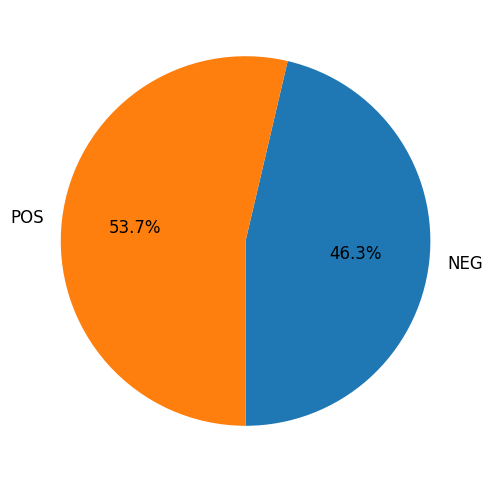

In [26]:
# Count the number of tweets by sentiments
sentiment_counts = df.groupby(['sentiment']).size()
print("2021")
print(sentiment_counts)

# Visualize the sentiments
fig = plt.figure(figsize=(6,6), dpi=100)
ax = plt.subplot(111)
sentiment_counts.plot.pie(ax=ax, autopct='%1.1f%%', startangle=270, fontsize=12, label="")

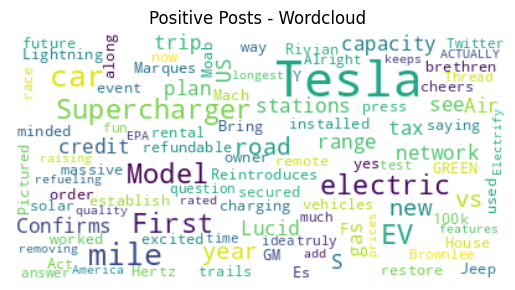

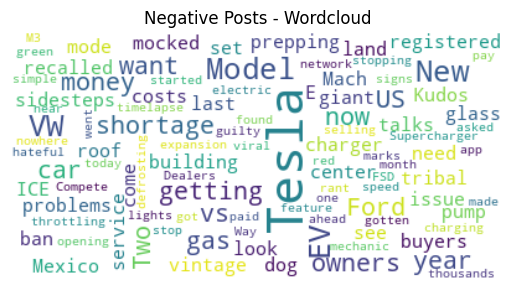

In [27]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS

# Wordcloud with positive posts
positive_posts = df['title'][df["sentiment"] == 'POS']
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
positive_wordcloud = WordCloud(max_font_size=40, max_words=100, background_color="white", stopwords = stop_words).generate(str(positive_posts))
plt.figure()
plt.title("Positive Posts - Wordcloud")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Wordcloud with negative posts
negative_posts = df['title'][df["sentiment"] == 'NEG']
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
negative_wordcloud = WordCloud(max_font_size=40, max_words=100, background_color="white", stopwords = stop_words).generate(str(negative_posts))
plt.figure()
plt.title("Negative Posts - Wordcloud")
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

,title,sentiment
6,"I just bought the only EV in the country, the South Pacific island nation of Vanuatu. Then we sat in a ferry for 30 hours to my home island. I'm very happy with this Geely Geometry C, Geely have done a great job with loads of features. Meant to be a copy of a Tesla model Y.",POS


,title,sentiment
0,"I am kind of ashamed of owning a Tesla, which makes me sad.",NEG


2022
sentiment
NEG    37
POS    12
dtype: int64


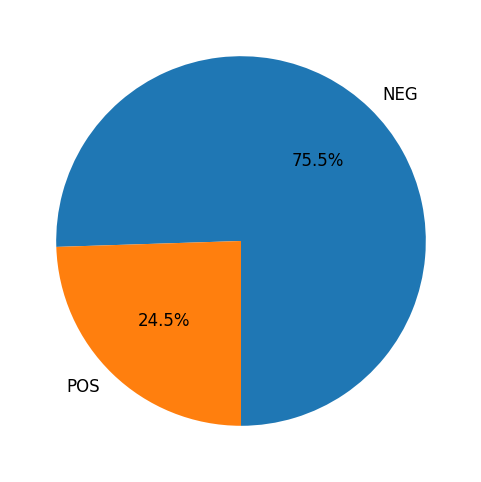

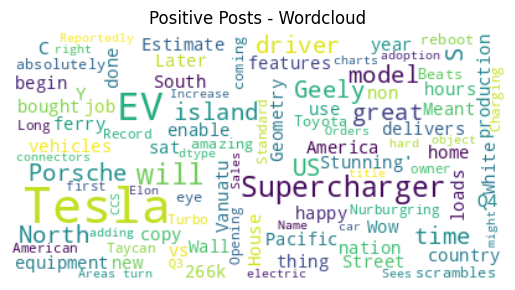

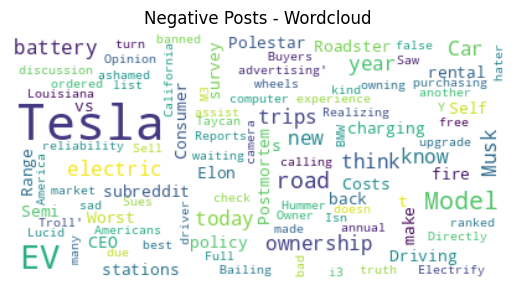

In [28]:
# My model:
# year 2022
# Load the data in a dataframe
df = pd.DataFrame(posts[1])
pd.set_option('display.max_colwidth', None)

# Show a post for each sentiment
display(df[df["sentiment"] == 'POS'].head(1))
# display(df[df["sentiment"] == 'NEU'].head(1))
display(df[df["sentiment"] == 'NEG'].head(1))

# Count the number of tweets by sentiments
sentiment_counts = df.groupby(['sentiment']).size()
print("2022")
print(sentiment_counts)

# Visualize the sentiments
fig = plt.figure(figsize=(6,6), dpi=100)
ax = plt.subplot(111)
sentiment_counts.plot.pie(ax=ax, autopct='%1.1f%%', startangle=270, fontsize=12, label="")

# Wordcloud with positive posts
positive_posts = df['title'][df["sentiment"] == 'POS']
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
positive_wordcloud = WordCloud(max_font_size=40, max_words=100, background_color="white", stopwords = stop_words).generate(str(positive_posts))
plt.figure()
plt.title("Positive Posts - Wordcloud")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Wordcloud with negative posts
negative_posts = df['title'][df["sentiment"] == 'NEG']
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
negative_wordcloud = WordCloud(max_font_size=40, max_words=100, background_color="white", stopwords = stop_words).generate(str(negative_posts))
plt.figure()
plt.title("Negative Posts - Wordcloud")
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

,title,sentiment
1,All Ford EV will have access to Tesla Supercharger network,POS


,title,sentiment
0,"Disapproval of Elon Musk is top reason Tesla owners are selling, survey says",NEG


2023
sentiment
NEG    59
POS    28
dtype: int64


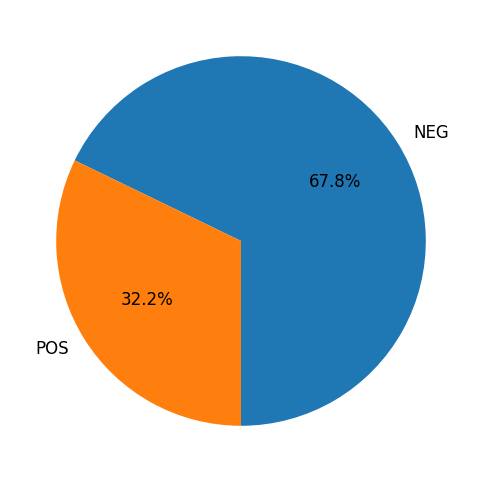

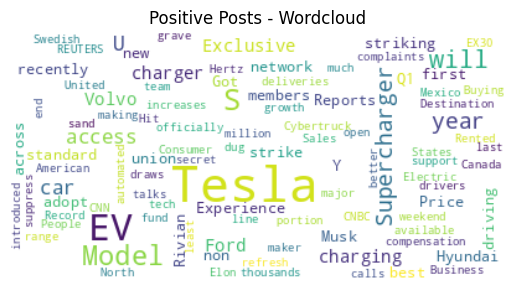

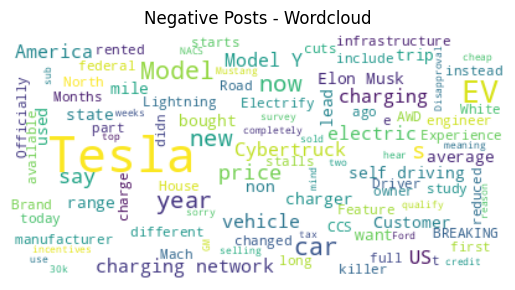

In [29]:
# My model:
# year 2023
# Load the data in a dataframe
df = pd.DataFrame(posts[2])
pd.set_option('display.max_colwidth', None)

# Show a post for each sentiment
display(df[df["sentiment"] == 'POS'].head(1))
# display(df[df["sentiment"] == 'NEU'].head(1))
display(df[df["sentiment"] == 'NEG'].head(1))

# Count the number of tweets by sentiments
sentiment_counts = df.groupby(['sentiment']).size()
print("2023")
print(sentiment_counts)

# Visualize the sentiments
fig = plt.figure(figsize=(6,6), dpi=100)
ax = plt.subplot(111)
sentiment_counts.plot.pie(ax=ax, autopct='%1.1f%%', startangle=270, fontsize=12, label="")

# Wordcloud with positive posts
positive_posts = df['title'][df["sentiment"] == 'POS']
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
positive_wordcloud = WordCloud(max_font_size=40, max_words=100, background_color="white", stopwords = stop_words).generate(str(positive_posts))
plt.figure()
plt.title("Positive Posts - Wordcloud")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Wordcloud with negative posts
negative_posts = df['title'][df["sentiment"] == 'NEG']
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
negative_wordcloud = WordCloud(max_font_size=40, max_words=100, background_color="white", stopwords = stop_words).generate(str(negative_posts))
plt.figure()
plt.title("Negative Posts - Wordcloud")
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

,title,sentiment
6,The Cybertruck Seems to Be Breaking Down at an Incredible Rate,POS


,title,sentiment
0,Buyers Are Avoiding Teslas Because Elon Musk Has Become So Toxic,NEG


2024
sentiment
NEG    32
POS     6
dtype: int64


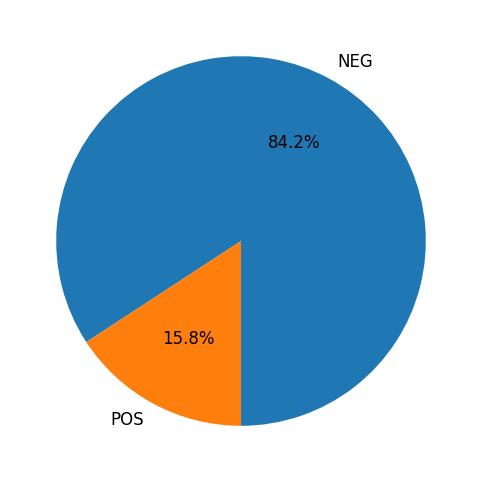

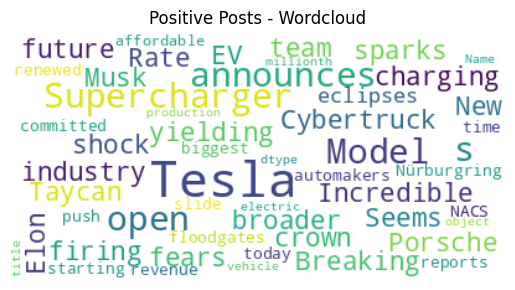

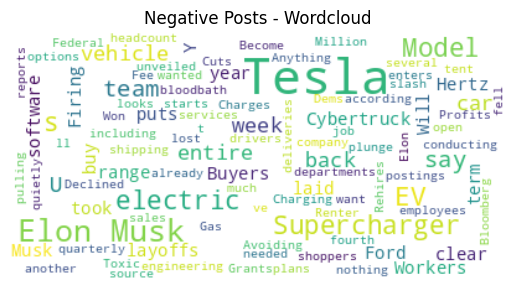

In [30]:
# My model:
# year 2024
# Load the data in a dataframe
df = pd.DataFrame(posts[3])
pd.set_option('display.max_colwidth', None)

# Show a post for each sentiment
display(df[df["sentiment"] == 'POS'].head(1))
# display(df[df["sentiment"] == 'NEU'].head(1))
display(df[df["sentiment"] == 'NEG'].head(1))

# Count the number of tweets by sentiments
sentiment_counts = df.groupby(['sentiment']).size()
print("2024")
print(sentiment_counts)

# Visualize the sentiments
fig = plt.figure(figsize=(6,6), dpi=100)
ax = plt.subplot(111)
sentiment_counts.plot.pie(ax=ax, autopct='%1.1f%%', startangle=270, fontsize=12, label="")

# Wordcloud with positive posts
positive_posts = df['title'][df["sentiment"] == 'POS']
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
positive_wordcloud = WordCloud(max_font_size=40, max_words=100, background_color="white", stopwords = stop_words).generate(str(positive_posts))
plt.figure()
plt.title("Positive Posts - Wordcloud")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Wordcloud with negative posts
negative_posts = df['title'][df["sentiment"] == 'NEG']
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
negative_wordcloud = WordCloud(max_font_size=40, max_words=100, background_color="white", stopwords = stop_words).generate(str(negative_posts))
plt.figure()
plt.title("Negative Posts - Wordcloud")
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

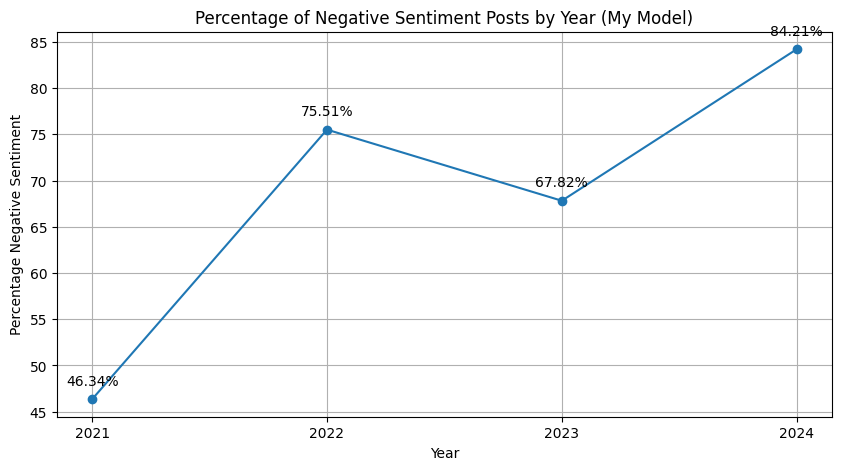

In [31]:
# Dictionary to store the percentage of negative sentiment posts
percent_negative = {}

# Analyze data for each year
for i, year_data in enumerate(posts, start=2021):
    df = pd.DataFrame(year_data)
    sentiment_counts = df['sentiment'].value_counts(normalize=True) * 100  # Get percentage counts
    percent_negative[i] = sentiment_counts.get('NEG', 0)  # Get negative percentage or 0 if none

# Plotting
years = list(percent_negative.keys())
negative_percentages = list(percent_negative.values())

plt.figure(figsize=(10, 5))
plt.plot(years, negative_percentages, marker='o')
plt.title('Percentage of Negative Sentiment Posts by Year (My Model)')
plt.xlabel('Year')
plt.ylabel('Percentage Negative Sentiment')
plt.xticks(years)  # Ensure all years are labeled

# Adding labels to each data point
for i, txt in enumerate(negative_percentages):
    plt.annotate(f"{txt:.2f}%", (years[i], negative_percentages[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.grid(True)
plt.show()

# Comparison with a trained model

In [32]:
# Load the data in a dataframe
df = pd.DataFrame(posts2[0])
pd.set_option('display.max_colwidth', None)

# Show a post for each sentiment
display(df[df["sentiment"] == 'POS'].head(1))
display(df[df["sentiment"] == 'NEU'].head(1))
display(df[df["sentiment"] == 'NEG'].head(1))

,title,sentiment
0,Tesla just secured a massive order of 100k vehicles for Hertz rental,POS


,title,sentiment
1,"US House Reintroduces GREEN Act, which would restore tax credits for GM and Tesla, establish new used EV refundable tax credit",NEU


,title,sentiment
11,Tesla keeps raising prices and removing features 🤦🏻‍♂️,NEG


2021
sentiment
NEG     8
NEU    17
POS    16
dtype: int64


<Axes: >

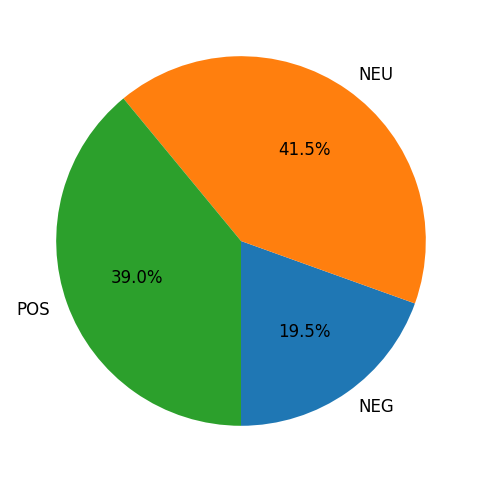

In [33]:
# Count the number of tweets by sentiments
sentiment_counts = df.groupby(['sentiment']).size()
print("2021")
print(sentiment_counts)

# Visualize the sentiments
fig = plt.figure(figsize=(6,6), dpi=100)
ax = plt.subplot(111)
sentiment_counts.plot.pie(ax=ax, autopct='%1.1f%%', startangle=270, fontsize=12, label="")

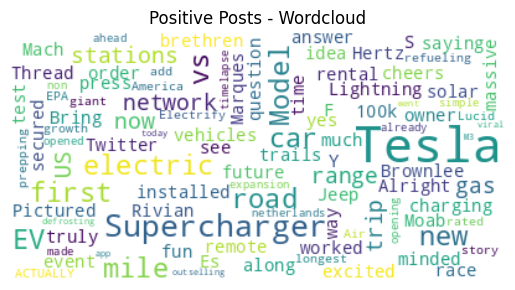

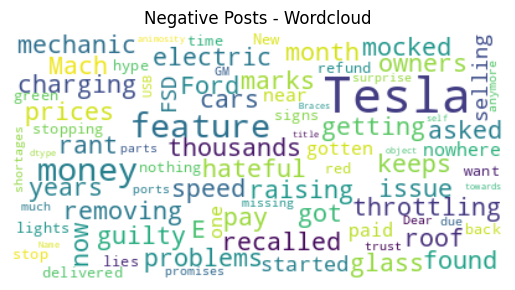

In [34]:
# Wordcloud with positive posts
positive_posts = df['title'][df["sentiment"] == 'POS']
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
positive_wordcloud = WordCloud(max_font_size=40, max_words=100, background_color="white", stopwords = stop_words).generate(str(positive_posts))
plt.figure()
plt.title("Positive Posts - Wordcloud")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Wordcloud with negative posts
negative_posts = df['title'][df["sentiment"] == 'NEG']
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
negative_wordcloud = WordCloud(max_font_size=40, max_words=100, background_color="white", stopwords = stop_words).generate(str(negative_posts))
plt.figure()
plt.title("Negative Posts - Wordcloud")
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

,title,sentiment
6,"I just bought the only EV in the country, the South Pacific island nation of Vanuatu. Then we sat in a ferry for 30 hours to my home island. I'm very happy with this Geely Geometry C, Geely have done a great job with loads of features. Meant to be a copy of a Tesla model Y.",POS


,title,sentiment
7,Opinion | Americans Are Realizing Tesla Isn’t the Only Electric Car -- the truth is that many of the best electric wheels on the market today are not made by Elon Musk.,NEU


,title,sentiment
0,"I am kind of ashamed of owning a Tesla, which makes me sad.",NEG


2022
sentiment
NEG    15
NEU    25
POS     9
dtype: int64


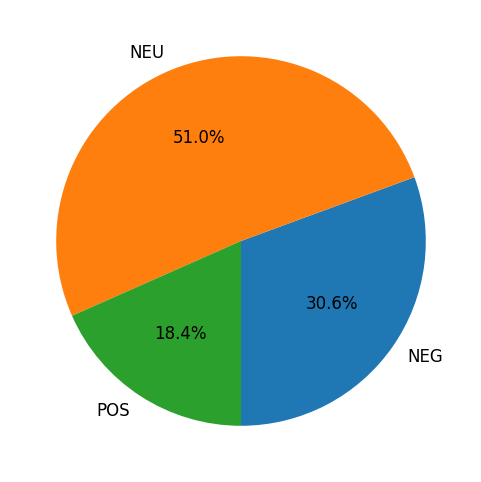

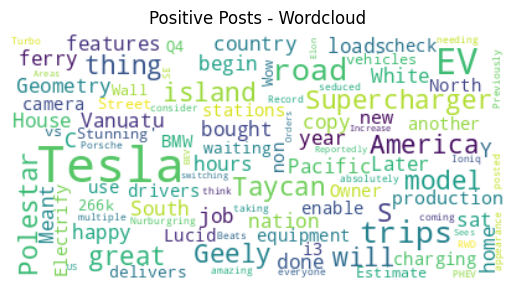

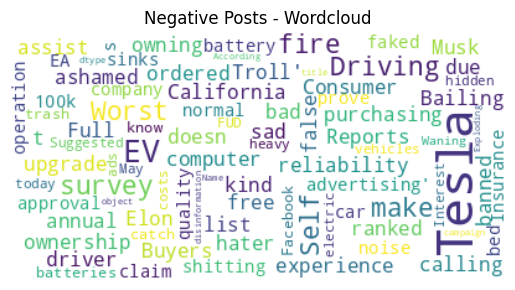

In [35]:
# Load the data in a dataframe
df = pd.DataFrame(posts2[1])
pd.set_option('display.max_colwidth', None)

# Show a post for each sentiment
display(df[df["sentiment"] == 'POS'].head(1))
display(df[df["sentiment"] == 'NEU'].head(1))
display(df[df["sentiment"] == 'NEG'].head(1))

# Count the number of tweets by sentiments
sentiment_counts = df.groupby(['sentiment']).size()
print("2022")
print(sentiment_counts)

# Visualize the sentiments
fig = plt.figure(figsize=(6,6), dpi=100)
ax = plt.subplot(111)
sentiment_counts.plot.pie(ax=ax, autopct='%1.1f%%', startangle=270, fontsize=12, label="")

# Wordcloud with positive posts
positive_posts = df['title'][df["sentiment"] == 'POS']
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
positive_wordcloud = WordCloud(max_font_size=40, max_words=100, background_color="white", stopwords = stop_words).generate(str(positive_posts))
plt.figure()
plt.title("Positive Posts - Wordcloud")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Wordcloud with negative posts
negative_posts = df['title'][df["sentiment"] == 'NEG']
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
negative_wordcloud = WordCloud(max_font_size=40, max_words=100, background_color="white", stopwords = stop_words).generate(str(negative_posts))
plt.figure()
plt.title("Negative Posts - Wordcloud")
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

,title,sentiment
1,All Ford EV will have access to Tesla Supercharger network,POS


,title,sentiment
2,GM to use Tesla charging network and NACS,NEU


,title,sentiment
0,"Disapproval of Elon Musk is top reason Tesla owners are selling, survey says",NEG


2023
sentiment
NEG    21
NEU    43
POS    23
dtype: int64


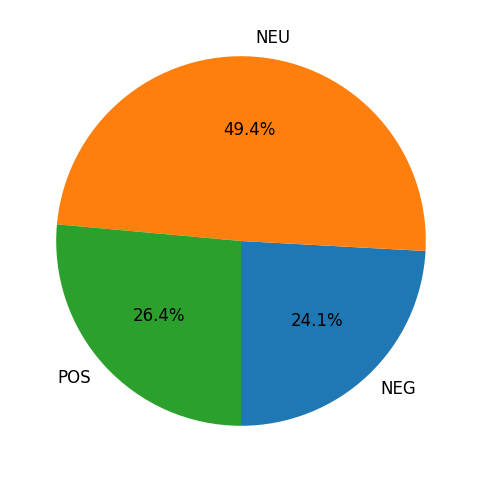

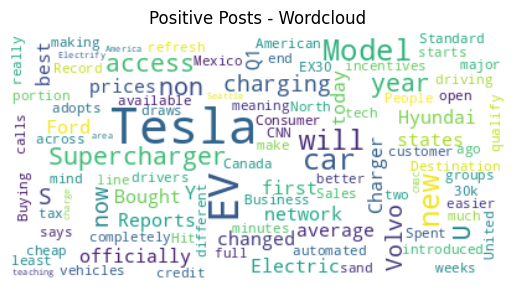

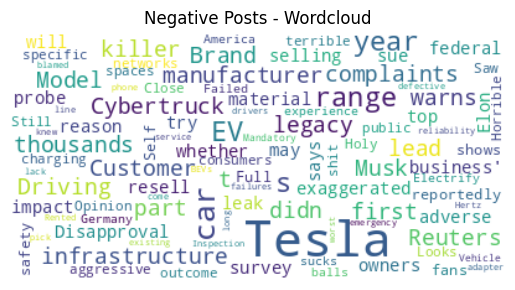

In [36]:
# Load the data in a dataframe
df = pd.DataFrame(posts2[2])
pd.set_option('display.max_colwidth', None)

# Show a post for each sentiment
display(df[df["sentiment"] == 'POS'].head(1))
display(df[df["sentiment"] == 'NEU'].head(1))
display(df[df["sentiment"] == 'NEG'].head(1))

# Count the number of tweets by sentiments
sentiment_counts = df.groupby(['sentiment']).size()
print("2023")
print(sentiment_counts)

# Visualize the sentiments
fig = plt.figure(figsize=(6,6), dpi=100)
ax = plt.subplot(111)
sentiment_counts.plot.pie(ax=ax, autopct='%1.1f%%', startangle=270, fontsize=12, label="")

# Wordcloud with positive posts
positive_posts = df['title'][df["sentiment"] == 'POS']
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
positive_wordcloud = WordCloud(max_font_size=40, max_words=100, background_color="white", stopwords = stop_words).generate(str(positive_posts))
plt.figure()
plt.title("Positive Posts - Wordcloud")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Wordcloud with negative posts
negative_posts = df['title'][df["sentiment"] == 'NEG']
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
negative_wordcloud = WordCloud(max_font_size=40, max_words=100, background_color="white", stopwords = stop_words).generate(str(negative_posts))
plt.figure()
plt.title("Negative Posts - Wordcloud")
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

,title,sentiment
19,Meta's CTO replaced his Tesla with an electric Mercedes: 'I didn't know cars could be this nice',POS


,title,sentiment
1,Elon lost Dems when Tesla needed them most,NEU


,title,sentiment
0,Buyers Are Avoiding Teslas Because Elon Musk Has Become So Toxic,NEG


2024
sentiment
NEG    15
NEU    17
POS     6
dtype: int64


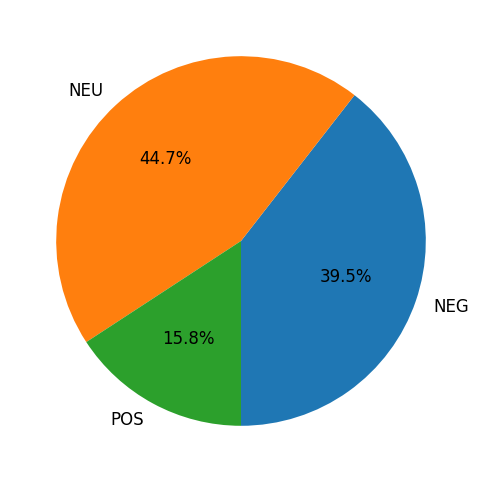

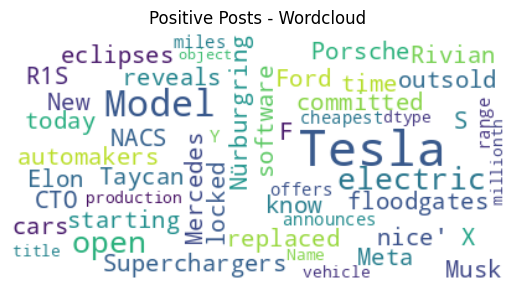

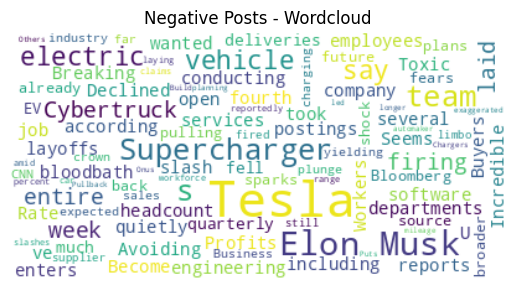

In [37]:
# Load the data in a dataframe
df = pd.DataFrame(posts2[3])
pd.set_option('display.max_colwidth', None)

# Show a post for each sentiment
display(df[df["sentiment"] == 'POS'].head(1))
display(df[df["sentiment"] == 'NEU'].head(1))
display(df[df["sentiment"] == 'NEG'].head(1))

# Count the number of tweets by sentiments
sentiment_counts = df.groupby(['sentiment']).size()
print("2024")
print(sentiment_counts)

# Visualize the sentiments
fig = plt.figure(figsize=(6,6), dpi=100)
ax = plt.subplot(111)
sentiment_counts.plot.pie(ax=ax, autopct='%1.1f%%', startangle=270, fontsize=12, label="")

# Wordcloud with positive posts
positive_posts = df['title'][df["sentiment"] == 'POS']
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
positive_wordcloud = WordCloud(max_font_size=40, max_words=100, background_color="white", stopwords = stop_words).generate(str(positive_posts))
plt.figure()
plt.title("Positive Posts - Wordcloud")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Wordcloud with negative posts
negative_posts = df['title'][df["sentiment"] == 'NEG']
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
negative_wordcloud = WordCloud(max_font_size=40, max_words=100, background_color="white", stopwords = stop_words).generate(str(negative_posts))
plt.figure()
plt.title("Negative Posts - Wordcloud")
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

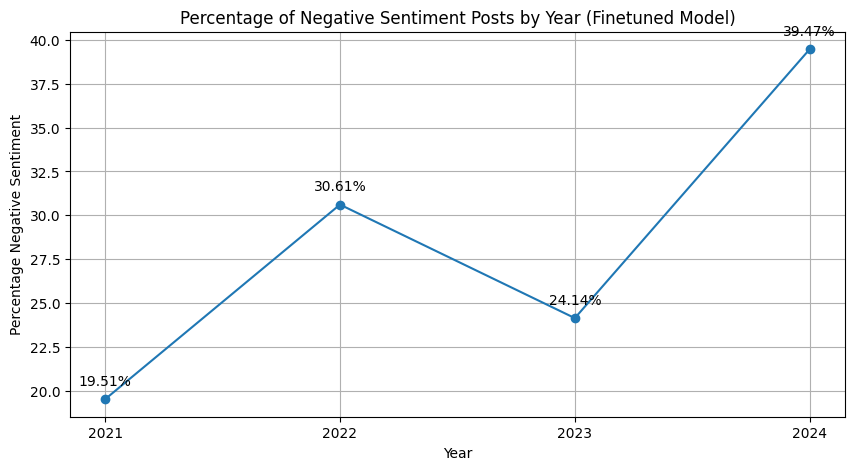

In [39]:
# Dictionary to store the percentage of negative sentiment posts
percent_negative = {}

# Analyze data for each year
for i, year_data in enumerate(posts2, start=2021):
    df = pd.DataFrame(year_data)
    sentiment_counts = df['sentiment'].value_counts(normalize=True) * 100  # Get percentage counts
    percent_negative[i] = sentiment_counts.get('NEG', 0)  # Get negative percentage or 0 if none

# Plotting
years = list(percent_negative.keys())
negative_percentages = list(percent_negative.values())

plt.figure(figsize=(10, 5))
plt.plot(years, negative_percentages, marker='o')
plt.title('Percentage of Negative Sentiment Posts by Year (Finetuned Model)')
plt.xlabel('Year')
plt.ylabel('Percentage Negative Sentiment')
plt.xticks(years)  # Ensure all years are labeled

# Adding labels to each data point
for i, txt in enumerate(negative_percentages):
    plt.annotate(f"{txt:.2f}%", (years[i], negative_percentages[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.grid(True)
plt.show()